In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rho_plus as rp
from scipy import stats
from tqdm import tqdm

theme, cs = rp.mpl_setup(True)

In [2]:
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team, Location, Outcome

def player_id(name):
    first, last = name.split(' ')
    return last.lower()[:5] + first.lower()[:2] + ('01' if name not in ('Jaylen Brown') else '02')

In [3]:
boxes = client.regular_season_player_box_scores(player_id('Jayson Tatum'), season_end_year=2022)

In [4]:
import datetime

def player_data(name):
    boxes = client.regular_season_player_box_scores(player_id(name), season_end_year=2022)
    df = pd.DataFrame([{k: v.name.lower() if isinstance(v, (Team, Location, Outcome)) else v for k, v in box.items()} for box in boxes])
    df.rename(columns={
        'made_field_goals': 'fgm',
        'attempted_field_goals': 'fga',
        'made_three_point_field_goals': '3pm',
        'attempted_three_point_field_goals': '3pa',
        'made_free_throws': 'ftm',
        'attempted_free_throws': 'fta',
        'offensive_rebounds': 'oreb',
        'defensive_rebounds': 'dreb',
        'assists': 'ast',
        'steals': 'stl',
        'blocks': 'blk',
        'turnovers': 'tov',
        'personal_fouls': 'pf',
        'game_score': 'game_score',
        'plus_minus': 'plus_minus'
    }, inplace=True)
    df['2pm'] = df['fgm'] - df['3pm']
    df['2pa'] = df['fga'] - df['3pa']
    df['2p%'] = df['2pm'] / df['2pa']
    df['3p%'] = df['3pm'] / df['3pa']
    df['ft%'] = df['ftm'] / df['fta']
    df['reb'] = df['oreb'] + df['dreb']
    df['pts'] = 3 * df['3pm'] + 2 * df['2pm'] + 1 * df['ftm']
    df['ts%'] = df['pts'] / (2 * (df['fga'] + 0.44 * df['fta']))
    df['won'] = df['outcome'] == 'win'
    df = df.sort_values('date')
    return df

tatum = player_data('Jayson Tatum')
st_curry = player_data('Stephen Curry')
se_curry = player_data('Seth Curry')
smart = player_data('Marcus Smart')
thompson = player_data('Klay Thompson')

<AxesSubplot:xlabel='day', ylabel='ft%'>

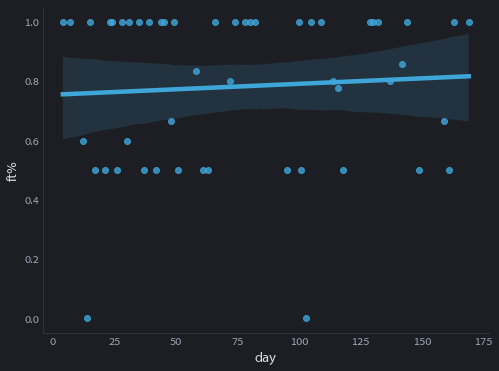

In [43]:
df = smart
df['day'] = (df['date'] - df['date'][0]).dt.days
sns.regplot(data=df, x='day', y='ft%')

In [44]:
import pymc as pm
import arviz as az
import bokeh
az.rcParams['plot.backend'] = 'matplotlib'

df = thompson
n = df['fta']
k = df['ftm']

mod = pm.Model()
with mod:
    u = pm.Beta('u', alpha=1, beta=1)
    # v = pm.HalfStudentT('v', nu=2, sigma=10)
    v = pm.HalfCauchy('v', beta=4)
    
    a = u * v
    b = (1 - u) * v

    obs = pm.BetaBinomial('obs', n=n, alpha=a, beta=b, observed=k)

with mod:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<AxesSubplot:title={'center':'u'}>,
        <AxesSubplot:title={'center':'u'}>],
       [<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>]], dtype=object)

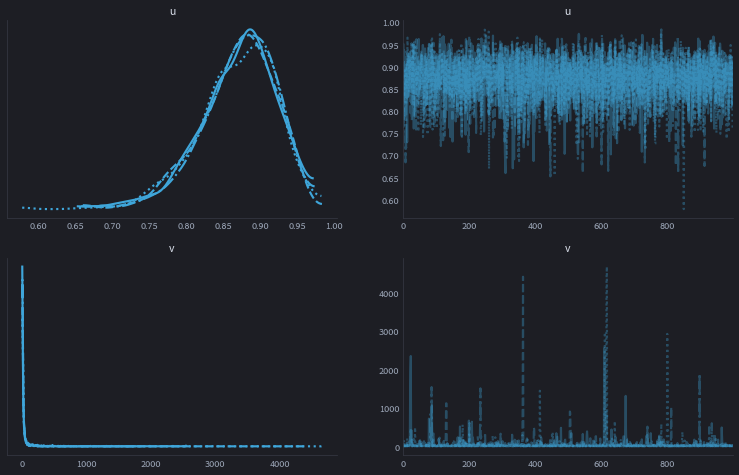

In [45]:
az.plot_trace(idata, figsize=(13, 8))

In [46]:
def quant_dispersion(quants):
    q = np.linspace(0, 1, len(quants))
    return np.mean((q - np.array(sorted(quants))) * np.sign(0.5 - q))

0.15130085951663888

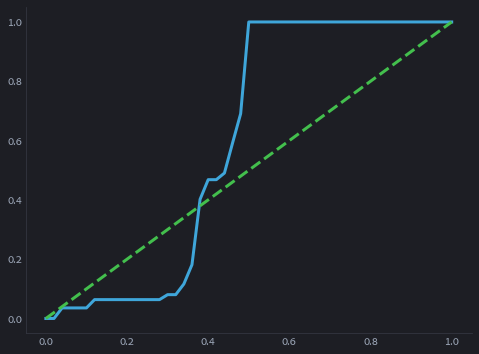

In [48]:
df = tatum


def dispersion(df, plot=False):
     u = df['ftm'].sum() / df['fta'].sum()

     quants = []
     for n, k in zip(df['fta'], df['ftm']):
          if n != 0:
               dist = stats.binom(n=n, p=u)
               quants.append(dist.cdf(k - 1) / (1 - dist.pmf(k)))
          
     xx = np.linspace(0, 1, len(quants))
     if plot:
          plt.plot(xx, sorted(quants))
          plt.plot(xx, xx, ls='--')

     return quant_dispersion(quants)

dispersion(smart, plot=True)

0.07287111267125025

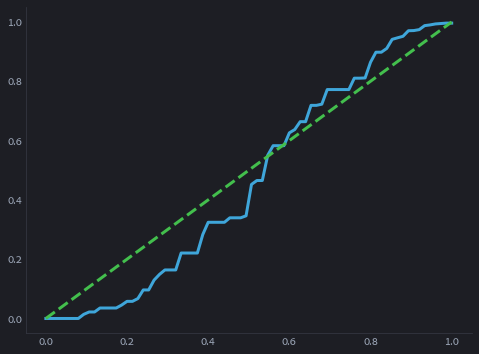

In [22]:
dispersion(tatum, plot=True)

0.04124761137524021

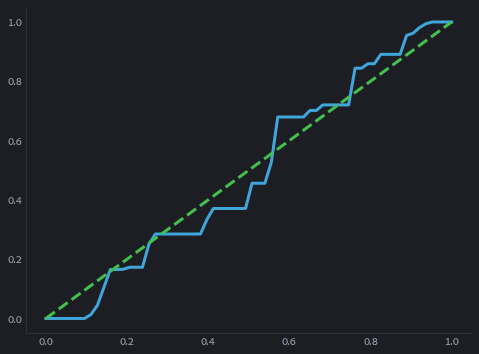

In [23]:
dispersion(se_curry, plot=True)

0.04519047927088941

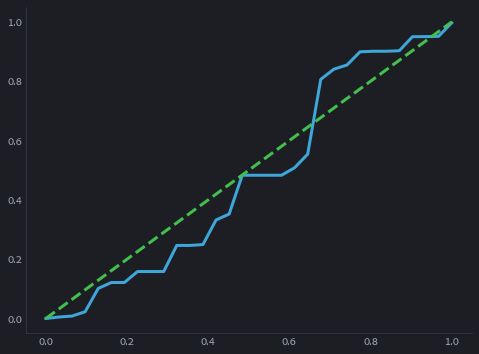

In [42]:
dispersion(player_data('Klay Thompson'), plot=True)

In [40]:
n = 10
kk = stats.binom(n=n, p=0.8).rvs(1000)

u = np.mean(kk) / n

quants = []
for k in kk:
    if n != 0:
        dist = stats.binom(n=n, p=u)
        quants.append(dist.cdf(k - 1) / (1 - dist.pmf(k)))
          
quant_dispersion(quants)

0.020565318497853348